In [1]:
# importing libraries
import pandas as pd
import numpy as np
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix
import pickle
# nltk.download('stopwords')
sns.set(style="darkgrid")

### Data Preprocessing and Analysis

In [4]:
# load data files
files = ['Chris_1.csv', 'Chris_2.csv', 'Flamingo_1.csv']
dataframes = []
for file in files:
    dataframes.append(pd.read_csv(file))

In [5]:
# merge all dataframes
df = pd.concat(dataframes, sort=True)
rows = df.shape[0]
df.shape

(7903, 3)

In [6]:
# check for rows with null or missing vals
df.isnull().sum()

Comment     8
Label       0
Username    1
dtype: int64

In [7]:
# remove rows with missing vals
df = df.dropna()
print("Removed", rows - df.shape[0] , "rows from data")
print("Dimensions of data", df.shape)

Removed 9 rows from data
Dimensions of data (7894, 3)


In [8]:
# basic info about data 
df.describe()

,Comment,Label,Username
count,7894,7894,7894
unique,7785,6,7572
top,a,0,Isaac Lee
freq,20,4853,19


In [9]:
# some info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7894 entries, 0 to 2595
Data columns (total 3 columns):
Comment     7894 non-null object
Label       7894 non-null object
Username    7894 non-null object
dtypes: object(3)
memory usage: 246.7+ KB


In [10]:
# check data types
df.dtypes

Comment     object
Label       object
Username    object
dtype: object

In [11]:
# check Label column in data
df['Label'].unique()

array(['0', '1', '-', 'q', 0, 1], dtype=object)

In [15]:
# remove rows with '-' as label in Label column
index = df[(df['Label'] != '0') & (df['Label'] != '1') & (df['Label'] != 0) & (df['Label'] != 1)].index
print("Dropped rows whose label is not 0 or 1:", len(index))
df = df.drop(index)

Dropped rows whose label is not 0 or 1: 0


In [16]:
# convert remaining labels from string to integer format
df['Label'] = df['Label'].astype(int)
df['Label'].unique()

array([0, 1])

In [17]:
# make copy of dataframe and initialize a stemmer
c = 'Comment'
data = df.copy()
stopwords = stopwords.words('english')
stemmer = PorterStemmer()

In [18]:
# remove special characters
data[c] = data[c].map(lambda x: re.sub(r'\W', ' ', x))

# replace multiple spaces with single space 
data[c] = data[c].map(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))

# remove all single characters
data[c] = data[c].map(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))

# covert text to lower case
data[c] = data[c].str.lower()

# tokenize text
data[c] = data[c].str.split()

# apply stemming
data[c] = data[c].map(lambda x: ' '.join([stemmer.stem(w) for w in x if w not in stopwords]))# check how many requests there are in the comments data

In [19]:
# check out the difference in distribution of request(1) vs. not-request comments(0)
requests = df[df['Label'] == 1]
not_requests = df[df['Label'] == 0]
print("Comments that are requests:", requests.shape[0])
print("Comments that are not requests:", not_requests.shape[0])
print("Percentage of requests in total comments data:", round(requests.shape[0]/df.shape[0] * 100, 2), "%")

Comments that are requests: 997
Comments that are not requests: 6893
Percentage of requests in total comments data: 12.64 %


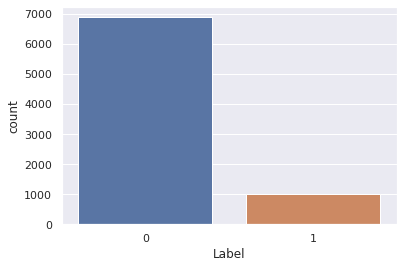

In [20]:
# visualize distribution of request vs. not-request comments
ax = sns.countplot(x="Label", data=df)

In [21]:
# change distribution of data by removing half of not-request comments
ratio = 0.3
not_requests = not_requests.sample(int(not_requests.shape[0] * ratio))
data = pd.concat([requests, not_requests])
data.shape

(3064, 3)

In [22]:
# reset index
data.reset_index(inplace=True, drop=True)
data.head()

,Comment,Label,Username
0,"Chris,please do review The Report on Amazon Pr...",1,Ashwin Varkey
1,Look up 'Chris Stuckmann Losing His Mind' on Y...,1,Nicholas Rytting
2,Chris there is a film Jalikattu. It’s mindblow...,1,kmkaks 2.0
3,"Chris, please do top 10 movies of 2019",1,Aravind P
4,"Hey chris, could you consider making a best mo...",1,ariff iqmal


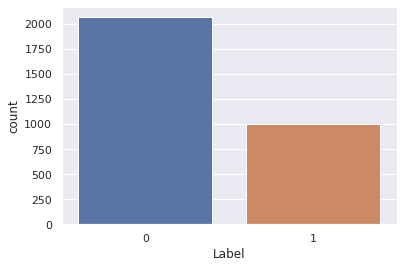

In [23]:
# now visualize the distribution of request vs. not-request comments
ax = sns.countplot(x="Label", data=data)

### Feature Engineering

In [24]:
# generate tf-idf vectors for comment column 
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)
X = tfidf.fit_transform(data['Comment'])

In [25]:
# train test split
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("Dimensions of train set", X_train.shape)
print("Dimensions of validation set", X_test.shape)

Dimensions of train set (2451, 2000)
Dimensions of validation set (613, 2000)


### Model Training

In [26]:
# train Linear SVM classifier
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
# make predictions on test set and print performance metrics
y_pred = classifier.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test,y_pred))
print("Model Accuracy:", round(accuracy_score(y_test, y_pred), 3))

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       402
           1       0.91      0.83      0.87       211

    accuracy                           0.92       613
   macro avg       0.91      0.90      0.90       613
weighted avg       0.92      0.92      0.91       613

Model Accuracy: 0.915


In [28]:
# print precision and recall scores for positive class (request --> 1)
precision_recall = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision:', precision_recall[0])
print('Recall:', precision_recall[1])
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Precision: 0.9119170984455959
Recall: 0.8341232227488151

Confusion Matrix:
 [[385  17]
 [ 35 176]]


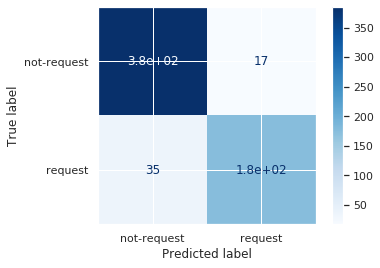

In [29]:
# display confusion matrix
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             display_labels=['not-request', 'request'],
                             cmap=plt.cm.Blues,
                             normalize=None)

In [30]:
# create a dict to save classifier, countvectorizer and tfidf objects
data = {'clf': classifier, 'tfidf': tfidf}

# save model in a pickle file
with open('svm.pkl', 'wb') as model:
    pickle.dump(data, model)

In [129]:
# precision = TP/ TP + FP
# TP = comment was a request and the model classified it as request
# FP = comment was not-request but model classified it as request

# recall = TP / TP + FN
# recall = ratio of comments that were classified as request over all the comments that are requests 
# TN = comment was not a request and the model classified it as not-request
# FN = comment was a request but was classified as not-request